<a href="https://colab.research.google.com/github/afrojaakter/FallResearch2021/blob/main/vrnn_classifier_zero_entry_until_last_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####RNN

In [1]:
# Numpy, JAX, Matplotlib and h5py should all be correctly installed and on the python path.
from __future__ import print_function, division, absolute_import
import datetime
import h5py
import jax.numpy as np
from jax import grad, jit, lax, random, vmap
from jax.experimental import optimizers
import matplotlib.pyplot as plt
import numpy as onp             # original CPU-backed NumPy
import os
import sys
import time
from importlib import reload
from functools import partial

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [2]:
def keygen(key, nkeys):
  """Generate randomness that JAX can use by splitting the JAX keys.
  Args:
    key : the random.PRNGKey for JAX
    nkeys : how many keys in key generator
  Returns:
    2-tuple (new key for further generators, key generator)
  """
  keys = random.split(key, nkeys+1)
  return keys[0], (k for k in keys[1:])

In [3]:
"""Vanilla RNN functions for init, definition and running."""
MAX_SEED_INT = 10000000

'''def random_vrnn_params(key, u, n, o, g=1.0):
  """Generate random RNN parameters"""

  key, skeys = keygen(key, 4)
  hscale = 0.1
  ifactor = 1.0 / np.sqrt(u)
  hfactor = g / np.sqrt(n)
  pfactor = 1.0 / np.sqrt(n)
  return {'h0' : random.normal(next(skeys), (n,)) * hscale,
          'wI' : random.normal(next(skeys), (n,u)) * ifactor,
          'wR' : random.normal(next(skeys), (n,n)) *  hfactor,
          'wO' : random.normal(next(skeys), (o,n)) * pfactor,
          'bR' : np.zeros([n]),
          'bO' : np.zeros([o])}'''
def random_vrnn_params(key, u, n, o, g=1.0):
  """Generate random RNN parameters"""

  key, skeys = keygen(key, 4)
  hscale = 0.1
  ifactor = 1.0 / np.sqrt(u)
  hfactor = g / np.sqrt(n)
  pfactor = 1.0 / np.sqrt(n)
  weight_dic = {}
  weight_dic['h0'] = random.normal(next(skeys), (n,)) * hscale
  MAX_SEED_INT = 10000001
  weight_dic['wI'] = random.normal(next(skeys), (n,u)) * ifactor
  weight_dic['wR'] = random.normal(next(skeys), (n,n)) *  hfactor
  weight_dic['wO'] = random.normal(next(skeys), (o,n)) * pfactor
  weight_dic['bR'] = np.zeros([n])
  weight_dic['bO'] = np.zeros([o])
  return weight_dic


def affine(params, x):
  """Implement y = w x + b"""
  return np.dot(params['wO'], x) + params['bO']


# Affine expects n_W_m m_x_1, but passing in t_x_m (has txm dims) So
# map over first dimension to hand t_x_m.  I.e. if affine yields 
# n_y_1 = dot(n_W_m, m_x_1), then batch_affine yields t_y_n.  
batch_affine = vmap(affine, in_axes=(None, 0))


def vrnn(params, h, x):
  """Run the Vanilla RNN one step"""
  a = np.dot(params['wI'], x) + params['bR'] + np.dot(params['wR'], h)
  return np.tanh(a)


def vrnn_scan(params, h, x):
  """Run the Vanilla RNN one step, returning (h ,h)."""  
  h = vrnn(params, h, x)
  return h, h


def vrnn_run_with_h0(params, x_t, h0):
  """Run the Vanilla RNN T steps, where T is shape[0] of input."""
  h = h0
  f = partial(vrnn_scan, params)
  _, h_t = lax.scan(f, h, x_t)
  o_t = batch_affine(params, h_t)
  return h_t, o_t

def vrnn_run(params, x_t):
  """Run the Vanilla RNN T steps, where T is shape[0] of input."""
  return vrnn_run_with_h0(params, x_t, params['h0'])

# Let's upgrade it to handle batches using `vmap`
# Make a batched version of the `predict` function
batched_rnn_run = vmap(vrnn_run, in_axes=(None, 0))
batched_rnn_run_w_h0 = vmap(vrnn_run_with_h0, in_axes=(None, 0, 0))
  
def loss(params, inputs_bxtxu, targets_bxtxo, l2reg):
  """Compute the least squares loss of the output, plus L2 regularization."""
  _, outs_bxtxo = batched_rnn_run(params, inputs_bxtxu)
  l2_loss = l2reg * optimizers.l2_norm(params)**2
  lms_loss = np.mean((outs_bxtxo - targets_bxtxo)**2)
  total_loss = lms_loss + l2_loss
  return {'total' : total_loss, 'lms' : lms_loss, 'l2' : l2_loss}

def update_w_gc(i, opt_state, opt_update, get_params, x_bxt, f_bxt,
                max_grad_norm, l2reg):
  """Update the parameters w/ gradient clipped, gradient descent updates."""
  params = get_params(opt_state)

  def training_loss(params, x_bxt, f_bxt, l2reg):
    return loss(params, x_bxt, f_bxt, l2reg)['total']
  
  grads = grad(training_loss)(params, x_bxt, f_bxt, l2reg)
  clipped_grads = optimizers.clip_grads(grads, max_grad_norm)
  return opt_update(i, clipped_grads, opt_state)


loss_jit = jit(loss)
update_w_gc_jit = jit(update_w_gc, static_argnums=(2,3))

def run_trials(batched_run_fun, inputs_targets_h0s_fun, nbatches, batch_size):
  """Run a bunch of trials and save everything in a dictionary."""
  inputs = []
  hiddens = []
  outputs = []
  targets = []
  h0s = []
  for n in range(nbatches):
    data_seeds = onp.random.randint(0, MAX_SEED_INT, size=batch_size)
    keys = np.array([random.PRNGKey(ds) for ds in data_seeds])
    input_b, target_b, h0s_b = inputs_targets_h0s_fun(keys)
    if h0s_b is None:
      h_b, o_b = batched_run_fun(input_b)
    else:
      h_b, o_b = batched_run_fun(input_b, h0s_b)      
      h0s.append(h0s_b)
      
    inputs.append(input_b)
    hiddens.append(h_b)
    outputs.append(o_b)
    targets.append(target_b)
    
  trial_dict = {'inputs' : onp.vstack(inputs), 'hiddens' : onp.vstack(hiddens),
                'outputs' : onp.vstack(outputs), 'targets' : onp.vstack(targets)}
  if h0s_b is not None:
    trial_dict['h0s'] = onp.vstack(h0s)
  else:
    trial_dict['h0s'] = None
  return trial_dict

def plot_params(params):
  """ Plot the parameters of the vanilla RNN. """
  plt.figure(figsize=(16,8))
  plt.subplot(231)
  plt.stem(params['wO'][0,:])
  plt.title('wO - output weights')
  
  plt.subplot(232)
  plt.stem(params['h0'])
  plt.title('h0 - initial hidden state')
  
  plt.subplot(233)
  plt.imshow(params['wR'], interpolation=None)
  plt.title('wR - recurrent weights')
  plt.colorbar()
  
  plt.subplot(234)
  plt.stem(params['wI'])
  plt.title('wI - input weights')
  
  plt.subplot(235)
  plt.stem(params['bR'])
  plt.title('bR - recurrent biases')

  plt.subplot(236)
  evals, _ = onp.linalg.eig(params['wR'])
  x = onp.linspace(-1, 1, 1000)
  plt.plot(x, onp.sqrt(1-x**2), 'k')
  plt.plot(x, -onp.sqrt(1-x**2), 'k')
  plt.plot(onp.real(evals), onp.imag(evals), '.')
  plt.axis('equal')
  plt.title('Eigenvalues of wR')

  
def plot_examples(ntimesteps, rnn_internals, nexamples=1):
  """Plot some input/hidden/output triplets."""
  plt.figure(figsize=(nexamples*5, 12))
  for bidx in range(nexamples):
    plt.subplot(3, nexamples, bidx+1)
    plt.plot(rnn_internals['inputs'][bidx,:], 'k')
    plt.xlim([0, ntimesteps])
    plt.title('Example %d' % (bidx))
    if bidx == 0:
      plt.ylabel('Input')
      
  ntoplot = 10
  closeness = 0.25
  for bidx in range(nexamples):
    plt.subplot(3, nexamples, nexamples+bidx+1)
    plt.plot(rnn_internals['hiddens'][bidx, :, 0:ntoplot] +
             closeness * onp.arange(ntoplot), 'b')
    plt.xlim([0, ntimesteps])
    if bidx == 0:
      plt.ylabel('Hidden Units')
      
  for bidx in range(nexamples):
    plt.subplot(3, nexamples, nexamples+bidx+1)
    heatmap = plt.imshow(rnn_internals['hiddens'][bidx, :, :].T, origin = 'lower', aspect= 'auto')
    cbar = plt.colorbar(heatmap, orientation='horizontal') 
    if bidx == 0:
      plt.ylabel('Hidden Units')
      
  for bidx in range(nexamples):
    plt.subplot(3, nexamples, 2*nexamples+bidx+1)
    plt.plot(rnn_internals['outputs'][bidx,:,:], 'r')
    plt.plot(rnn_internals['targets'][bidx,:,:], 'k')    
    plt.xlim([0, ntimesteps])
    plt.xlabel('Timesteps')
    if bidx == 0:
      plt.ylabel('Output')

####Integrator

In [4]:
"""Routines for creating white noise and integrated white noise."""
def build_input_and_target_pure_integration(input_params, key):
  bias_val, stddev_val, T, ntime = input_params
  dt = T/ntime
  # Create the white noise input.
  key, skeys = keygen(key, 2)
  random_sample = random.normal(next(skeys), (1,))[0]
  bias = bias_val * 2.0 * (random_sample - 0.5)
  stddev = stddev_val / np.sqrt(dt)
  random_samples = random.normal(next(skeys), (ntime,))
  noise_t = stddev * random_samples
  white_noise_t = bias + noise_t

  pure_integration_t = np.cumsum(white_noise_t)
  decision = 2.0*((pure_integration_t[-1] > 0.0)-0.5)
  targets_t = np.zeros(pure_integration_t.shape[0]-1)
  targets_t = np.concatenate([targets_t,
                              np.array([decision], dtype=float)], axis=0)
  inputs_tx1 = np.expand_dims(white_noise_t, axis=1)
  targets_tx1 = np.expand_dims(targets_t, axis=1)
  target_mask = np.array([ntime-1]) # When target is defined.
  print('targetMstk', target_mask)
  return inputs_tx1, targets_tx1, target_mask

# Now batch it and jit.
build_input_and_target = build_input_and_target_pure_integration
build_inputs_and_targets = vmap(build_input_and_target, in_axes=(None, 0))
build_inputs_and_targets_jit = jit(build_inputs_and_targets,
                                   static_argnums=(0,))

def plot_batch(ntimesteps, input_bxtxu, target_bxtxo=None, output_bxtxo=None,
               errors_bxtxo=None):
  """Plot some white noise / integrated white noise examples."""
  ntoplot = 10
  plt.figure(figsize=(10,7))
  plt.subplot(311)
  plt.plot(input_bxtxu[0:ntoplot,:,0].T)
  plt.xlim([0, ntimesteps-1])
  plt.ylabel('Noise')
  plt.subplot(312)
  if output_bxtxo is not None:
    plt.plot(output_bxtxo[0:ntoplot,:,0].T, label = 'Predicted value');
    plt.xlim([0, ntimesteps-1]);
  if target_bxtxo is not None:
    plt.plot(target_bxtxo[0:ntoplot,:,0].T, '--',label = 'True value');
    plt.xlim([0, ntimesteps-1]);
    plt.ylabel("Decision")
  if errors_bxtxo is not None:
    plt.subplot(313)
    plt.plot(errors_bxtxo[0:ntoplot,:,0].T, '--');
    plt.xlim([0, ntimesteps-1]);
    plt.ylabel("|Errors|")
  plt.xlabel('Timesteps')

Hyperparameters

In [5]:
# Integration parameters
T = 1.0          # Arbitrary amount time, roughly physiological.
ntimesteps = 25  # Divide T into this many bins
bval = 0.01      # bias value limit
sval = 0.025     # standard deviation (before dividing by sqrt(dt))
input_params = (bval, sval, T, ntimesteps)

# Integrator RNN hyperparameters
u = 1         # Number of inputs to the RNN
n = 100       # Number of units in the RNN
o = 1         # Number of outputs in the RNN

# The scaling of the recurrent parameters in an RNN really matters. 
# The correct scaling is 1/sqrt(number of recurrent inputs), which 
# yields an order 1 signal output to a neuron if the input is order 1.
# Given that VRNN uses a tanh nonlinearity, with min and max output 
# values of -1 and 1, this works out.  The scaling just below 1 
# (0.95) is because we know we are making a line attractor so, we 
# might as well start it off basically right 1.0 is also basically 
# right, but perhaps will lead to crazier dynamics.
param_scale = 0.85 # Scaling of the recurrent weight matrix

# Optimization hyperparameters
num_batchs = 10000         # Total number of batches to train on.
batch_size = 128          # How many examples in each batch
eval_batch_size = 1024    # How large a batch for evaluating the RNN
step_size = 0.025          # initial learning rate
decay_factor = 0.99975     # decay the learning rate this much
# Gradient clipping is HUGELY important for training RNNs
max_grad_norm = 10.0      # max gradient norm before clipping, clip to this value.
l2reg = 0.0002           # amount of L2 regularization on the weights
adam_b1 = 0.9             # Adam parameters
adam_b2 = 0.999
adam_eps = 1e-1
print_every = 1000          # Print training informatino every so often

Seed: 295809
targetMstk Traced<ShapedArray(int32[1])>with<DynamicJaxprTrace(level=0/1)>


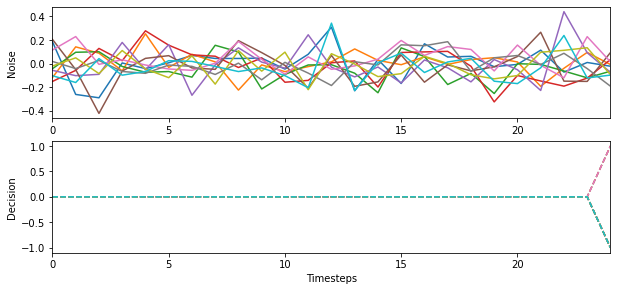

In [6]:
seed = onp.random.randint(0, 1000000) # get randomness from CPU level numpy
print("Seed: %d" % seed)
key = random.PRNGKey(seed) # create a random key for jax for use on device.

# Plot a few input/target examples to make sure things look sane.
ntoplot = 10    # how many examples to plot
key, skey = random.split(key, 2)
skeys = random.split(skey, ntoplot) # get ntoplot random keys
inputs, targets,_ = build_inputs_and_targets_jit(input_params, skeys)

# Plot the input to the RNN and the target for the RNN.
plot_batch(ntimesteps, inputs, targets)

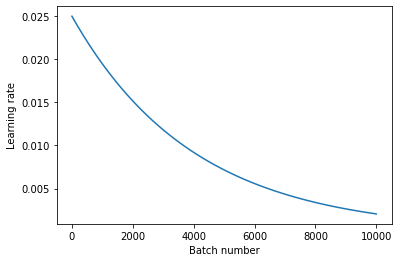

In [7]:
## Create a decay function for the learning rate
decay_fun = optimizers.exponential_decay(step_size, decay_steps=1, 
                                         decay_rate=decay_factor)

batch_idxs = onp.linspace(1, num_batchs)
plt.plot(batch_idxs, [decay_fun(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:141: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warni

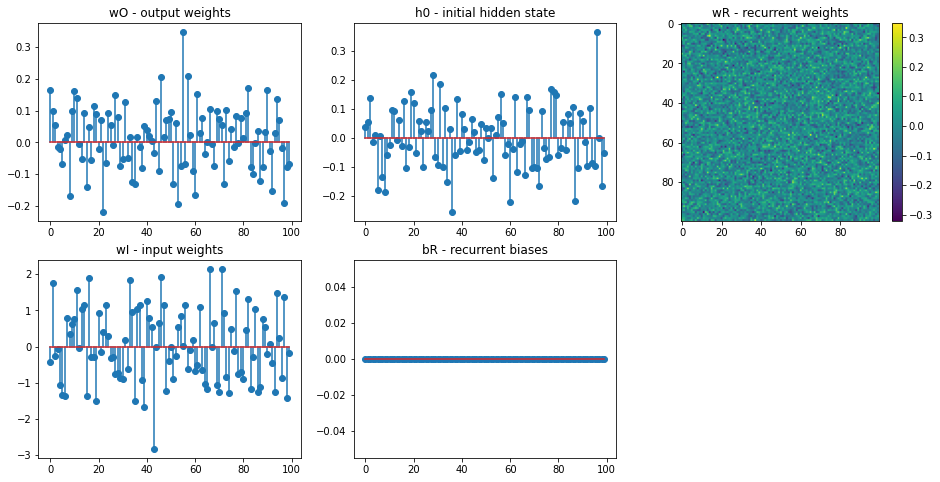

In [8]:
# Init some parameters for training.
key, subkey = random.split(key, 2)
init_params = random_vrnn_params(subkey, u, n, o, g=param_scale)
plot_params(init_params)

In [9]:
# Initialize the optimizer.  Please see jax/experimental/optimizers.py
opt_init, opt_update, get_params = optimizers.adam(decay_fun, adam_b1, adam_b2, adam_eps)
opt_state = opt_init(init_params)

# Run the optimization loop, first jit'd call will take a minute.
start_time = time.time()
all_train_losses = []
for batch in range(num_batchs):
    key, subkey = random.split(key, 2)
    skeys = random.split(subkey, batch_size)
    inputs, targets,_ = build_inputs_and_targets_jit(input_params, skeys)
    opt_state = update_w_gc_jit(batch, opt_state, opt_update, get_params, inputs,
                                  targets, max_grad_norm, l2reg)
    if batch % print_every == 0:
        params = get_params(opt_state)
        all_train_losses.append(loss_jit(params, inputs, targets, l2reg))
        train_loss = all_train_losses[-1]['total']
        batch_time = time.time() - start_time
        step_size = decay_fun(batch)
        s = "Batch {} in {:0.2f} sec, step size: {:0.5f}, training loss {:0.4f}"
        print(s.format(batch, batch_time, step_size, train_loss))
        start_time = time.time()
        
# List of dicts to dict of lists
all_train_losses = {k: [dic[k] for dic in all_train_losses] for k in all_train_losses[0]}

targetMstk Traced<ShapedArray(int32[1])>with<DynamicJaxprTrace(level=0/1)>
Batch 0 in 4.08 sec, step size: 0.02500, training loss 0.0836
Batch 1000 in 9.80 sec, step size: 0.01947, training loss 0.0597
Batch 2000 in 9.74 sec, step size: 0.01516, training loss 0.0645
Batch 3000 in 9.77 sec, step size: 0.01181, training loss 0.0343
Batch 4000 in 9.69 sec, step size: 0.00920, training loss 0.0324
Batch 5000 in 9.70 sec, step size: 0.00716, training loss 0.0308
Batch 6000 in 9.82 sec, step size: 0.00558, training loss 0.0294
Batch 7000 in 9.75 sec, step size: 0.00434, training loss 0.0268
Batch 8000 in 9.73 sec, step size: 0.00338, training loss 0.0277
Batch 9000 in 9.89 sec, step size: 0.00263, training loss 0.0251


Testing

In [10]:
# Take a batch for an evalulation loss, notice the L2 penalty is 0
# for the evaluation.
params = get_params(opt_state)

key, subkey = random.split(key, 2)
skeys = random.split(subkey, batch_size)
inputs, targets,_ = build_inputs_and_targets_jit(input_params, skeys)
eval_loss = loss_jit(params, inputs, targets, l2reg=0.0)['total']
eval_loss_str = "{:.5f}".format(eval_loss)
print("Loss on a new large batch: %s" % (eval_loss_str))

Loss on a new large batch: 0.00749


####Visualizations of trained system

In [11]:
from sklearn.decomposition import PCA

def plot_examples_residuals(ntimesteps, rnn_internals, nexamples=1):
  row =7
  plt.figure(figsize=(nexamples*6, 25))
  
  for bidx in range(nexamples):
    plt.subplot(row, nexamples, bidx+1)
    plt.plot(rnn_internals['inputs'][bidx,:], 'k')
    plt.xlim([0, ntimesteps])
    plt.title('Example %d' % (bidx))
    if bidx == 0:
      plt.ylabel('Input')
      
  ntoplot = 10
  '''
  for bidx in range(nexamples):
    plt.subplot(row, nexamples, nexamples+bidx+1)
    heatmap = plt.imshow(rnn_internals['hiddens'][bidx, :, :].T, origin = 'lower', aspect= 'auto')
    cbar = plt.colorbar(heatmap, orientation='horizontal') 
    if bidx == 0:
      plt.ylabel('Hidden Units')'''
  for bidx in range(nexamples):
    plt.subplot(row, nexamples, nexamples+bidx+1)
    heatmap = plt.imshow(rnn_internals['hiddens'][bidx, :, :].T[Idx,:], origin = 'lower', aspect= 'auto')
    cbar = plt.colorbar(heatmap, orientation='horizontal') 
    if bidx == 0:
      plt.ylabel('Sorted Hidden Units')

  for bidx in range(nexamples):
    plt.subplot(row, nexamples, 2*nexamples+bidx+1)
    heatmap = plt.imshow(rnn_internals['hiddens'][bidx+1, :, :].T[Idx,:] - A, origin = 'lower', aspect= 'auto')
    cbar = plt.colorbar(heatmap, orientation='horizontal') 
    if bidx == 0:
      plt.ylabel('Hidden Units Residue')#(sorted hidden units - sorted mean)

  for bidx in range(nexamples):
    '''SVD'''
    plt.subplot(row, nexamples, 3*nexamples+bidx+1)
    Residue = rnn_internals['hiddens'][bidx+1, :, :].T[Idx,:] - A
    U, S, VT = np.linalg.svd(Residue, full_matrices=False, compute_uv=True)
    S = np.diag(S)
    r = 1
    Residue_approx = U[:, :r] @ S[:r, :r] @ VT[:r, :]

    heatmap = plt.imshow(Residue_approx, origin = 'lower', aspect= 'auto')
    cbar = plt.colorbar(heatmap, orientation='horizontal') 
    if bidx == 0:
      plt.ylabel('Residue_SVD'+str(r))

  for bidx in range(nexamples):
    plt.subplot(row, nexamples, 4*nexamples+bidx+1)
    Residue = rnn_internals['hiddens'][bidx+1, :, :].T[Idx,:] - A
    U, S, VT = np.linalg.svd(Residue, full_matrices=False, compute_uv=True)
    
    plt.plot(VT[:r, :].reshape(-1,1), label = 'VT of rank-1 SVD')
    plt.plot(onp.cumsum(rnn_internals['inputs'][bidx,:,:]), label = 'input_sum_t')
    plt.legend()

  for bidx in range(nexamples):
    plt.subplot(row, nexamples, 5*nexamples+bidx+1)
    plt.plot(rnn_internals['outputs'][bidx,:,:], 'r')
    plt.plot(rnn_internals['targets'][bidx,:,:], 'k')    
    plt.xlim([0, ntimesteps])
    
    if bidx == 0:
      plt.ylabel('Output')
    plt.xlabel('Timesteps')

  for bidx in range(nexamples):
    #PCA
    n_activity = rnn_internals['hiddens'][bidx+1, :, :].T[Idx,:]
    ax = plt.subplot(row, nexamples, 6*nexamples+bidx+1, projection='3d')
    pca = PCA(n_components=2)
    n_activity_pca3 = pca.fit_transform(n_activity.T)
    t_range = [i for i in range(len(n_activity_pca3))]

    ax.plot(t_range, n_activity_pca3[:,0], n_activity_pca3[:,1],  'g^--')
    ax.set_xlabel('Time')
    ax.set_ylabel('PC1')
    ax.set_zlabel('PC2')


targetMstk Traced<ShapedArray(int32[1])>with<DynamicJaxprTrace(level=0/1)>


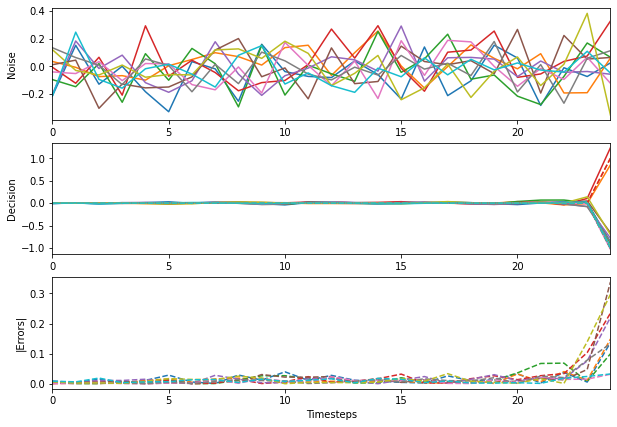

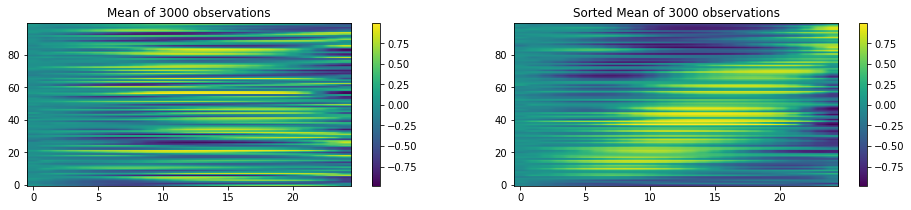

In [12]:
# Visualize how good this trained integrator is
def inputs_targets_no_h0s(keys):
    inputs_b, targets_b,_ = build_inputs_and_targets_jit(input_params, keys)
    h0s_b = None # Use trained h0
    return inputs_b, targets_b, h0s_b

rnn_run = lambda inputs: batched_rnn_run(params, inputs)
give_trained_h0 = lambda batch_size : np.array([params['h0']] * batch_size)

T = 1.0         # Arbitraty amount time, roughtly physiological
ntimesteps = 25
input_params = (bval, sval, T, ntimesteps)
nexamples = 3000

rnn_internals = run_trials(rnn_run, inputs_targets_no_h0s, 1, nexamples)

plot_batch(ntimesteps, rnn_internals['inputs'], 
          rnn_internals['targets'], rnn_internals['outputs'], 
          onp.abs(rnn_internals['targets'] - rnn_internals['outputs']))

H = rnn_internals['hiddens']
h = H[0,:,:]
for i in range(1,nexamples):
  h += H[i,:,:] 
ht = h.T/nexamples

plt.figure(figsize=(16,3))
plt.subplot(1,2,1)
heatmap = plt.imshow(ht, origin = 'lower', aspect= 'auto')
plt.title('Mean of 3000 observations')
plt.colorbar(heatmap)

time_location = []
for j in range(n):
  postn = onp.argmax(ht[j,:])
  time_location.append(postn)
time_location = np.array(time_location)

Idx = np.argsort(time_location)
A = ht[Idx,:]

plt.subplot(1,2,2)
heatmap = plt.imshow(A, origin = 'lower', aspect= 'auto')
plt.title('Sorted Mean of 3000 observations')
plt.colorbar(heatmap)


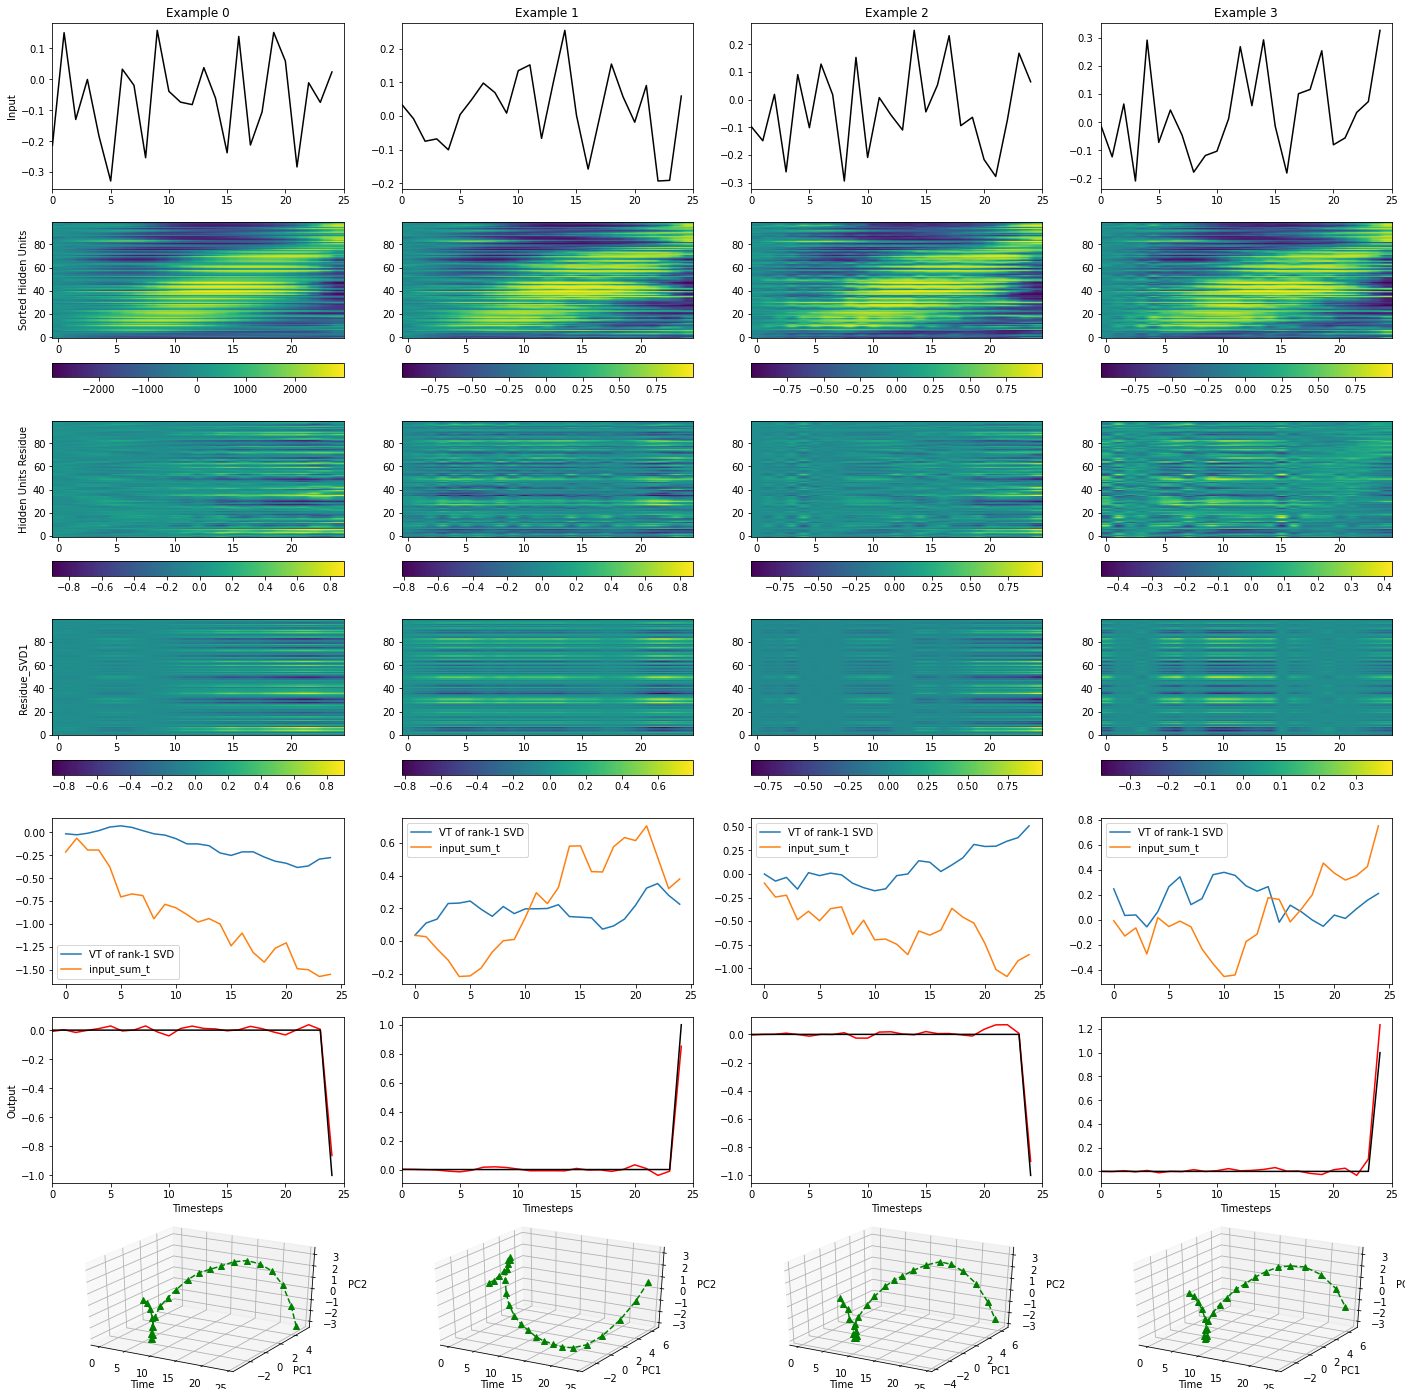

In [13]:
plot_examples_residuals(ntimesteps, rnn_internals, nexamples=4)